## exp4. 인공지능으로 작사하기

커널정보 = base(python. 3.9.7)

### 0. 루브릭
***

|**평가문항**|**상세기준**|
|------------|-------------|
|1. 가사 텍스트 생성 모델이 정상적으로 동작하는가?|텍스트 제너레이션 결과가 그럴듯한 문장으로 생성되는가?|
|2. 데이터의 전처리와 데이터셋 구성 과정이 체계적으로 진행되었는가?|특수문자 제거, 토크나이저 생성, 패딩처리 등의 과정이 빠짐없이 진행되었는가?|
|3. 텍스트 생성모델이 안정적으로 학습되었는가?|텍스트 생성모델의 validation loss가 2.2 이하로 낮아졌는가?|

### 1. 데이터 읽어오기

In [60]:
import re    
import glob
import numpy as np         
import tensorflow as tf   

txt_file_path = 'C:/project/aiffel_exp/exp4_lyricist/song_lyrics/*.txt'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r", encoding="UTF-8") as f:
        raw = f.read().splitlines() # 코드를 그대로 사용하니 unicodedecodeerror 발생하여 인코딩 추가
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:/n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['Looking for some education', 'Made my way into the night', 'All that bullshit conversation']


### 2. 데이터 정제

In [61]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜁니다.

    if idx > 9: break   # 일단 문장 10개만 확인해 볼 겁니다.
        
    print(sentence)

Looking for some education
Made my way into the night
All that bullshit conversation
Baby, can't you read the signs? I won't bore you with the details, baby
I don't even wanna waste your time
Let's just say that maybe
You could help me ease my mind
I ain't Mr. Right But if you're looking for fast love
If that's love in your eyes
It's more than enough


#### 2.1 문장 전처리

In [62]:
# 입력된 문장을
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
    sentence = re.sub(r"([?.!,¿])", r" /1 ", sentence) # 2. 특수문자 양쪽에 공백을 넣고
    sentence = re.sub(r'[" "]+', " ", sentence) # 3. 여러개의 공백은 하나의 공백으로 바꿉니다
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4 a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
    sentence = sentence.strip() # 5. 다시 양쪽 공백을 지웁니다
    sentence = '<start> ' + sentence + ' <end>' # 6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


In [63]:
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
        
    corpus.append(preprocess_sentence(sentence))
        
corpus[:10]

['<start> looking for some education <end>',
 '<start> made my way into the night <end>',
 '<start> all that bullshit conversation <end>',
 '<start> baby , can t you read the signs ? i won t bore you with the details , baby <end>',
 '<start> i don t even wanna waste your time <end>',
 '<start> let s just say that maybe <end>',
 '<start> you could help me ease my mind <end>',
 '<start> i ain t mr . right but if you re looking for fast love <end>',
 '<start> if that s love in your eyes <end>',
 '<start> it s more than enough <end>']

#### 2.2 데이터 토큰화

In [64]:
def tokenize(corpus):
    # 텐서플로우에서 제공하는 Tokenizer 패키지를 생성
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=7000,  # 전체 단어의 개수 
        filters=' ',    # 별도로 전처리 로직을 추가할 수 있습니다. 이번에는 사용하지 않겠습니다.
        oov_token="<unk>"  # out-of-vocabulary, 사전에 없었던 단어는 어떤 토큰으로 대체할지
    )
    tokenizer.fit_on_texts(corpus) # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다

    # 이후 tokenizer를 활용하여 모델에 입력할 데이터셋을 구축하게 됩니다.
    tensor = tokenizer.texts_to_sequences(corpus)   # tokenizer는 구축한 사전으로부터 corpus를 해석해 Tensor로 변환합니다.
	
    total_data_text = list(tensor)
    num_tokens = [len(tokens) for tokens in total_data_text]
    max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
    maxlen = int(max_tokens)
    # 입력 데이터의 시퀀스 길이를 일정하게 맞추기 위한 padding  메소드를 제공합니다.
    # maxlen의 디폴트값은 None입니다. 이 경우 corpus의 가장 긴 문장을 기준으로 시퀀스 길이가 맞춰집니다.
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, 
                                                           padding='post',
                                                           maxlen=maxlen)  

    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[  2 304  28 ...   0   0   0]
 [  2 221  13 ...   0   0   0]
 [  2  24  17 ...   0   0   0]
 ...
 [  2  23  77 ...   0   0   0]
 [  2  42  26 ...   0   0   0]
 [  2  23  77 ...   0   0   0]] <keras_preprocessing.text.Tokenizer object at 0x000001ED4FF7DD30>


In [65]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


In [66]:
src_input = tensor[:, :-1]  # tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다. 마지막 토큰은 <END>가 아니라 <pad>일 가능성이 높습니다.
tgt_input = tensor[:, 1:]    # tensor에서 <START>를 잘라내서 타겟 문장을 생성합니다.

print(src_input[0])
print(tgt_input[0])

[   2  304   28   99 4811    3    0    0    0    0    0    0    0    0
    0    0    0    0    0]
[ 304   28   99 4811    3    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]


### 3. 평가 데이터셋 분리

In [67]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(src_input, 
                                                  tgt_input, 
                                                  test_size=0.2,
                                                  shuffle=True, 
                                                  random_state=28)

In [68]:
print('Source Train: ', x_train.shape)
print('Target Train: ', y_train.shape)

Source Train:  (140599, 19)
Target Train:  (140599, 19)


In [69]:
def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

### 4. 인공지능 모델 만들기

In [70]:
'''
tk.keras.Model을 Subclassing 하는 방식
1개의 Embedding 레이어, 2개의 LSTM 레이어, 1개의 Dense 레이어 구성
Embedding 레이어는 단어 사전 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔줌. 
이 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현(representation)으로 사용됨

embedding_size는 워드 벡터의 차원수, 단어가 추상적으로 표현되는 크기.
값이 커질수록 단어의 추상적인 특징을 잘 잡아내지만, 충분한 데이터가 없다면 오히려 성능이 나빠진다

LSTM레이어의 hidden_size도 같은 맥락
'''
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 128
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [72]:
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(256, 19, 7001), dtype=float32, numpy=
array([[[ 2.40984118e-05, -1.07947213e-04, -1.03680264e-04, ...,
          2.66595521e-07, -1.04283645e-04,  2.41109701e-05],
        [ 1.79955750e-04,  2.08718066e-05,  8.62319357e-05, ...,
          1.88446080e-04,  5.38512868e-05, -1.07840009e-04],
        [ 6.90610905e-05,  2.27180368e-04,  4.73558321e-04, ...,
          1.90554289e-04,  3.54801705e-05, -4.24237718e-04],
        ...,
        [ 1.74816453e-03, -1.40232535e-03,  6.48529269e-04, ...,
         -1.10207824e-03, -2.23955652e-03, -1.34260650e-03],
        [ 1.81755284e-03, -1.47206022e-03,  6.70320704e-04, ...,
         -1.09431718e-03, -2.28799763e-03, -1.27019361e-03],
        [ 1.87198201e-03, -1.52461650e-03,  6.87184220e-04, ...,
         -1.07834034e-03, -2.32337974e-03, -1.20212149e-03]],

       [[ 2.40984118e-05, -1.07947213e-04, -1.03680264e-04, ...,
          2.66595521e-07, -1.04283645e-04,  2.41109701e-05],
        [ 1.44515770e-05, -6.57005221e-05,  9.

In [73]:
model.summary()

Model: "text_generator_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     multiple                  896128    
                                                                 
 lstm_6 (LSTM)               multiple                  4722688   
                                                                 
 lstm_7 (LSTM)               multiple                  8392704   
                                                                 
 dense_3 (Dense)             multiple                  7176025   
                                                                 
Total params: 21,187,545
Trainable params: 21,187,545
Non-trainable params: 0
_________________________________________________________________


In [74]:
history = []
epochs = 10

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)

history = model.fit(x_train, 
                    y_train, 
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
550/550 [==============================] - 73s 128ms/step - loss: 2.8574 - val_loss: 2.5750
Epoch 2/10
550/550 [==============================] - 77s 141ms/step - loss: 2.4606 - val_loss: 2.4109
Epoch 3/10
550/550 [==============================] - 81s 147ms/step - loss: 2.3239 - val_loss: 2.3045
Epoch 4/10
550/550 [==============================] - 81s 148ms/step - loss: 2.2219 - val_loss: 2.2361
Epoch 5/10
550/550 [==============================] - 80s 145ms/step - loss: 2.1436 - val_loss: 2.1824
Epoch 6/10
550/550 [==============================] - 81s 147ms/step - loss: 2.0760 - val_loss: 2.1430
Epoch 7/10
550/550 [==============================] - 82s 149ms/step - loss: 2.0152 - val_loss: 2.1045
Epoch 8/10
550/550 [==============================] - 73s 133ms/step - loss: 1.9578 - val_loss: 2.0751
Epoch 9/10
550/550 [==============================] - 71s 129ms/step - loss: 1.9036 - val_loss: 2.0479
Epoch 10/10
550/550 [==============================] - 71s 129ms/step - l

에포크를 30회 줬을 때 3시간정도 소요되어 10회로 수정했으나  
valid loss가 계속 감소하여, valid loss가 증가하는 지점을 찾기위해 에포크를 좀 더 늘리고 다시 학습하였다

In [75]:
history = []
epochs = 20

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)

history = model.fit(x_train, 
                    y_train, 
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
550/550 [==============================] - 84s 149ms/step - loss: 1.8276 - val_loss: 2.0254
Epoch 2/20
550/550 [==============================] - 82s 149ms/step - loss: 1.7513 - val_loss: 2.0093
Epoch 3/20
550/550 [==============================] - 81s 148ms/step - loss: 1.6975 - val_loss: 1.9953
Epoch 4/20
550/550 [==============================] - 85s 154ms/step - loss: 1.6465 - val_loss: 1.9857
Epoch 5/20
550/550 [==============================] - 83s 150ms/step - loss: 1.5963 - val_loss: 1.9741
Epoch 6/20
550/550 [==============================] - 72s 131ms/step - loss: 1.5470 - val_loss: 1.9660
Epoch 7/20
550/550 [==============================] - 80s 145ms/step - loss: 1.4991 - val_loss: 1.9595
Epoch 8/20
550/550 [==============================] - 72s 130ms/step - loss: 1.4520 - val_loss: 1.9553
Epoch 9/20
550/550 [==============================] - 81s 148ms/step - loss: 1.4054 - val_loss: 1.9527
Epoch 10/20
550/550 [==============================] - 81s 147ms/step - l

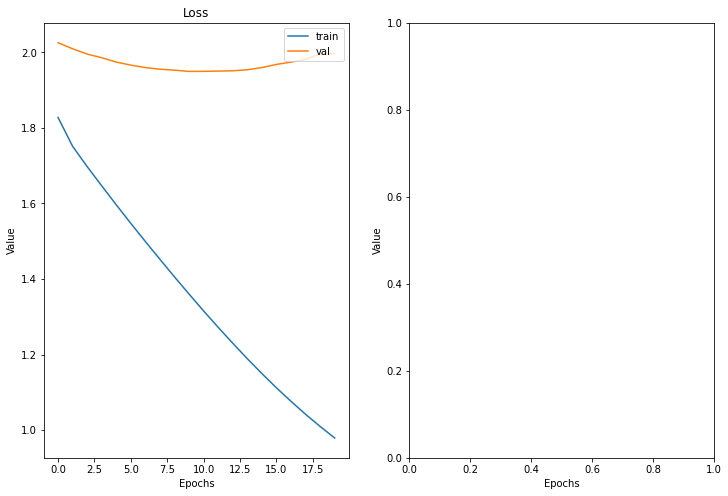

In [76]:
plot_curve(history.epoch, history.history, ['loss', 'val_loss'])

epoch를 20회로 주자 valid loss의 최적점을 찾았다.
train loss는 epoch 회차가 갈수록 점차 감소하여 과적합을 보여준다.

`embedding_size = 128`  
`hidden_size = 1024`

위의 세팅에서는 epoch 10회가 최적으로 보인다.

### 5. 모델 평가하기

In [77]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=200):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [78]:
generate_text(model, tokenizer, init_sentence="<start> how")

'<start> how many times i gotta tell that ass to come over ? <end> '

In [89]:
generate_text(model, tokenizer, init_sentence="<start> why")

'<start> why do you love me <end> '

성공적인지는 모르겠으나 어색함없는 문장이 출력된다.

#### 6. 느낀점

1. epoch 횟수의 조절은 과적합을 해결하는 직접적인 수단이기 보단 train loss와 valid loss의 증감 추세를 확인하는데 적합하다고 느꼈다.

2. 1의 이유로 다양한 `epoch`와 `embedding_size`, `hidden_size` 조절을 시도하여 정확도를 높여보고 싶었으나 이번 exp는 한번 모델을 fit하는데 엄청난 시간이 필요하여 시도하지 못한게 좀 아쉽다.

3. node에서 배운 `tf.data.Dataset`을 활용한 평가 데이터 셋 분리를 수행하지 못해 아쉽다. 아무생각없이 따라했다가 valid data가 없는걸 깨달고 처음부터 다시 했다. `tf.data.Dataset`로 train / valid / test 세가지 분류 하는 방법을 찾지 못해 결국 `train_test_split`으로 진행했다.

4. rnn의 개념과 텍스트 데이터를 전처리하는 과정을 배우고 직접 해보면서 재밌었다. 특히 전처리 과정은 과거에 고객데이터를 피벗을 돌리기위해 고민하고 고생했던 기억이 떠올라 여러 감정이 들었다.